In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core import Backtest, PlotPoint, IStrategy
from IPython.core.display import display, HTML
import talib
from math import log
from tqdm.notebook import tqdm
display(HTML("<style>.container { width:100% !important; }</style>"))

In [29]:
class Jma_hard:
    def __init__(self, avg_len=65, jma_leng=12, phase_param=1, avg_vol_len=10):
        # first initialization
        self.avg_len = avg_len
        self.jma_leng = jma_leng
        self.phase_param = phase_param
        self.avg_vol_len = avg_vol_len
        self.len_0 = (jma_leng - 1) / 2
        self.len_1 = max(log(self.len_0) / (2 * log(2)) + 2, 0)
        self.len_2 = self.len_1 * (self.len_0 ** 0.5)
        self.beta_2 = self.len_2 / (self.len_2 + 1)
        self.kv = self.beta_2
        self.pow_1 = max(self.len_1 - 2, 0.5)
        self.beta = 0.45 *(self.jma_leng - 1) / (0.45 * (self.jma_leng - 1) + 2)
        self.alpha = self.beta
        #self.upper_band, self.lower_band, self.m1, self.m2, self.jma = test[0], test[0], test[0], test[0], test[0]
        self.initialized = False
        self.delta_1, self.delta_2, self.volty, self.v_sum, self.avg_volty, self.t0, self.t1 = 0, 0, 0, 0, 0, 0, 0
        self.r_volty, self.power = 1, 1
        self.volty_history = [0]
    
    
    def iterate_by_data(self, test):
        output = []
        for price in test:
            output.append(self.calc_jma(price))
        return output
            
    
    def calc_jma(self, price):
        if not self.initialized:
            self.initialized = True
            self.upper_band, self.lower_band, self.m1, self.m2, self.jma = price, price, price, price, price
        self.delta_1 = price - self.upper_band
        self.delta_2 = price - self.lower_band
        if abs(self.delta_1) == abs(self.delta_2):
            volty = 0
        else:
            volty = max(abs(self.delta_1), abs(self.delta_2))
        self.volty_history.append(volty)
        self.v_sum = np.array(self.volty_history[-10:]).mean()
        self.avg_volty = self.avg_volty + 2 * (self.v_sum - self.avg_volty) / (self.avg_len + 1)
        if self.avg_volty > 0:
            self.r_volty = max(min(volty / self.avg_volty, self.len_1 ** (1 / self.pow_1)), 1)
        else:
            self.r_volty = 1
        self.power = self.r_volty ** self.pow_1
        self.alpha = self.beta ** self.power
        self.kv = self.beta_2 ** (self.power ** 0.5)
        
        if self.delta_2 < 0:
            self.lower_band = price
        else:
            self.lower_band = price - self.kv * self.delta_2
        if self.delta_1 > 0:
            self.upper_band = price
        else:
            self.upper_band = price - self.kv * self.delta_1
            
        self.m1 = (1 - self.alpha) * price + self.alpha * self.m1
        self.t0 = (price - self.m1) * (1 - self.beta) + (self.beta * self.t0)
        self.m2 = self.m1 + self.t0 * self.phase_param
        self.t1 = (self.m2 - self.jma) * (1 - self.alpha) * (1 - self.alpha) + (self.alpha ** 2) * self.t1
        self.jma = self.jma + self.t1
        return self.jma


In [12]:
data = pd.read_csv('BTCUSDT-15m-2021-03.csv')

In [21]:
data = data.rename({'45162.64':'Open', '45500.47':'High', '44972.49':'Low', '45498.26':'Close'}, axis=1)[['Open', 'High', 'Low', 'Close']]

In [ ]:
talib.EMA(feeds['BTC'].Close, timeperiod=20)

In [ ]:
talib.MOM(feeds['BTC'].Close, timeperiod=20)[0:300].plot()

In [30]:
hard_jma = Jma_hard(jma_leng=20, avg_len=65, phase_param=1, avg_vol_len=10)

In [31]:
hard_jma = Jma_hard(jma_leng=20, avg_len=65, phase_param=1, avg_vol_len=10)
hard_jma.iterate_by_data(data.Close[0:100])

[46181.33,
 46182.31723511789,
 46198.18945273813,
 46184.93705152035,
 46170.17459413036,
 46178.9233457336,
 46186.92620854686,
 46229.8208328227,
 46331.96935991229,
 46428.80117235701,
 46474.94101147244,
 46482.003553750255,
 46490.17753099739,
 46469.51507425245,
 46438.41787098758,
 46407.78755527021,
 46355.80729562831,
 46317.97966345472,
 46329.765565525835,
 46339.32965374483,
 46295.5568903405,
 46242.88039953487,
 46213.63920367162,
 46206.810673014465,
 46208.21229975146,
 46147.41978225161,
 46067.44176889601,
 46051.31985494569,
 46064.62453395783,
 46076.253927175945,
 46124.90179281463,
 46225.740113783315,
 46394.9675801599,
 46601.88954257507,
 46775.53847431281,
 46941.69977854574,
 47065.42851055561,
 47193.75533340572,
 47287.46492821312,
 47334.32845250951,
 47361.01909735708,
 47407.62402878882,
 47469.64679201458,
 47551.96038516692,
 47605.00743889271,
 47644.82051626758,
 47673.21896952515,
 47694.599959761246,
 47707.89736408377,
 47717.214258303604,
 47734

In [51]:
hard_jma.iterate_by_data(data.Close[0:100])[-2::]

[49735.982347956444, 49797.30753172234]

In [65]:
# strategy = Jma('BTC', 40, 1.5, 10, 60, 0.5, 10)

class Jma(IStrategy):
    def __init__(self, symbol1, jma_span_short, phase_short, vol_short, jma_span_long, phase_long, vol_long):
        self.jma_s = []
        self.jma_l = []
        self.price = []
        self.phase_l = phase_long
        self.phase_s = phase_short
        self.vol_l = vol_long
        self.vol_s = vol_short
        self.jma_span_l = jma_span_long
        self.jma_span_s = jma_span_short
        self.position = 0
        self.enter_price = None
        self.symbol1 = symbol1
        self.trades = []
    def _update_jma_s(self, feeds):
        hard_jma = Jma_hard(jma_leng=self.jma_span_s, avg_len=65, phase_param=self.phase_s, avg_vol_len=self.vol_s)
        self.jma_s = hard_jma.iterate_by_data(feeds[self.symbol1].close)

    def _update_jma_l(self, feeds):
        hard_jma = Jma_hard(jma_leng=self.jma_span_l, avg_len=65, phase_param=self.phase_l, avg_vol_len=self.vol_l)
        self.jma_l = hard_jma.iterate_by_data(feeds[self.symbol1].close)
        
        
    def make_decision(self, feeds):        
        self.price.append((feeds[self.symbol1].close[-1])) 
        self._update_jma_s(feeds)
        self._update_jma_l(feeds)

        if len(feeds[self.symbol1]) < (self.jma_span_l):
            return dict()

        if self.position == 1:
            if ((self.price[-1] > self.jma_l[-1]) | (self.jma_l[-1] < self.jma_s[-1])):
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.price) - 1,
                    name='exit_sell',
                    value=self.price[-1]
                ))                    
                return dict()
            else:
                return {self.symbol1: -1}
            
        elif self.position == -1:
            if ((self.price[-1] < self.jma_l[-1]) | (self.jma_l[-1] > self.jma_s[-1])):
                self.position = 0
                self.trades.append(PlotPoint(
                    tick=len(self.price) - 1,
                    name='exit_buy',
                    value=self.price[-1]
                ))  
                return dict()
            else:
                return {self.symbol1: 1}
        else:
            if ((self.price[-1] < self.jma_s[-1]) & (self.jma_s[-1] < self.jma_l[-1]) & (self.jma_s[-2:-1] > self.jma_l[-2:-1])):
                self.position = 1
                self.enter_price = self.price[-1]
                self.trades.append(PlotPoint(
                    tick=len(self.price) - 1,
                    name='enter_sell',
                    value=self.price[-1]
                ))
                return {self.symbol1: -1}
            
            elif ((self.price[-1] > self.jma_s[-1]) & (self.jma_s[-1] > self.jma_l[-1]) & (self.jma_s[-2:-1] < self.jma_l[-2:-1])):
                self.position = -1
                self.enter_price = self.price[-1]
                self.trades.append(PlotPoint(
                    tick=len(self.price) - 1,
                    name='enter_buy',
                    value=self.price[-1]
                ))
                return {self.symbol1: 1}            
            else:
                return dict()
    
    def get_plot_lines(self):
        return [
            {
                '{}'.format(self.symbol1): self.price,
                'jma short span={}'.format(self.jma_span_s): self.jma_s,
                'jma long span={}'.format(self.jma_span_l): self.jma_l
            },
        ]

    def get_plot_points(self):
        return [self.trades, []]

    def get_name(self):
        return 'Jma {}, position={}'.format(self.symbol1)

In [95]:
data = pd.read_csv('BTCUSDT-15m-2021-04.csv')

In [98]:
data

,Open,High,Low,Close
0,59046.64,59109.27,58950.01,58990.93
1,58990.93,59143.89,58990.93,59115.18
2,59115.18,59320.40,59084.89,59304.39
3,59304.39,59409.96,59214.87,59318.38
4,59318.39,59406.91,59153.18,59232.24
...,...,...,...,...
2874,57357.10,57371.40,57022.13,57143.26
2875,57143.26,57460.88,57107.76,57405.16
2876,57405.16,57500.00,57274.64,57486.20
2877,57486.20,57891.02,57400.01,57817.12


In [97]:
data = data.rename({'58810.99':'Open', '59180.00':'High', '58799.23':'Low', '59044.53':'Close'}, axis=1)[['Open', 'High', 'Low', 'Close']]

8015.369416000015

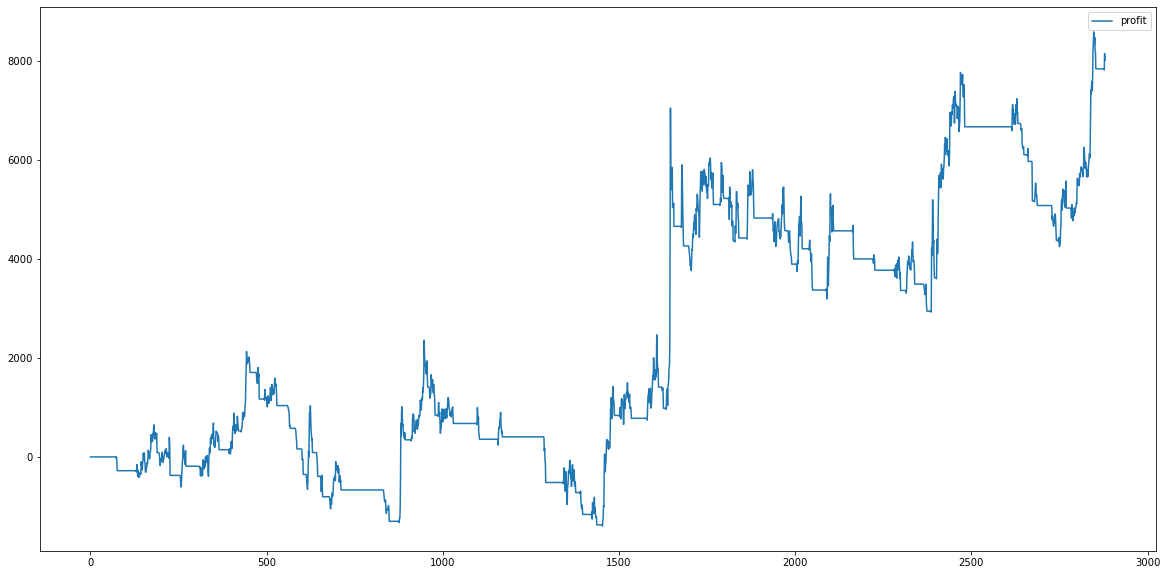

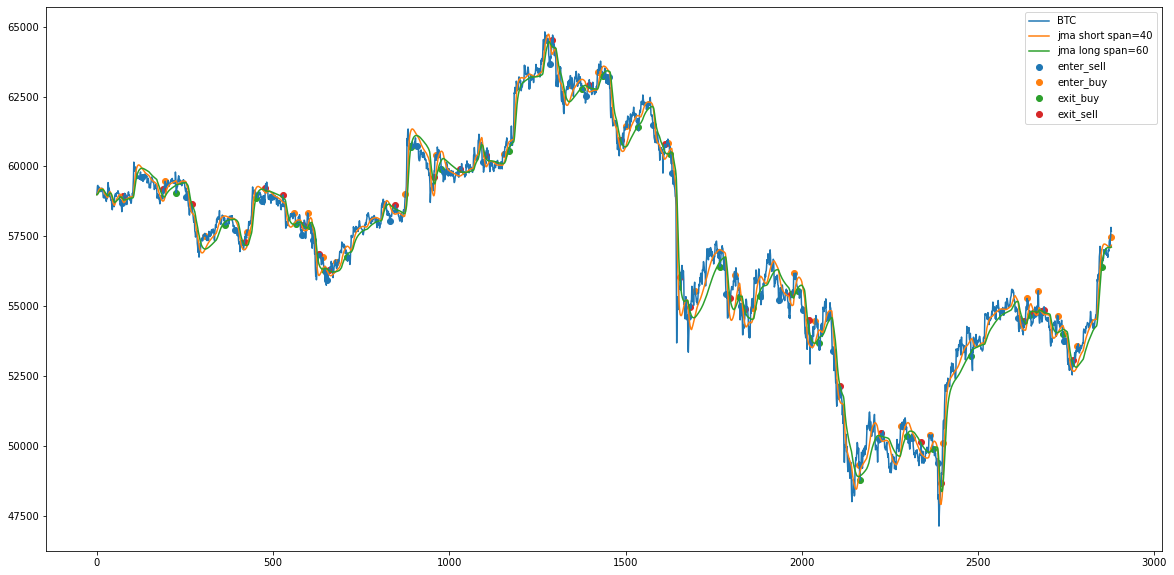

In [100]:
feeds = {
    'BTC': data,
}

strategy = Jma('BTC', 40, 1.5, 10, 60, 0.5, 10)
#strategy = Jma('BTC', 10, 2.5, 10, 40, 0.5, 10)
#strategy = Jma('BTC', 40, 2.5, 10, 60, 0.5, 10)
bt = Backtest(feeds, strategy)
bt.run(plot=True)['total_profit']

In [88]:
ii = []
jj = []
kk = []
tt = []
res = []
for i in tqdm([10, 40]):
    for j in [40, 60]:
        for k in [0.5, 1.5, 2.5]:
            for t in [0.5, 1.5, 2.5]:
                strategy = Jma('BTC', i, k, 10, j, t, 10)
                bt = Backtest(feeds, strategy)
                res.append(bt.run(plot=False)['total_profit'])
                ii.append(i)
                jj.append(j)
                kk.append(k)
                tt.append(t)

In [90]:
pd.DataFrame({'ii':ii, 'jj':jj, 'kk':kk, 'tt':tt, 'res':res}).sort_values(by='res').tail(15)

,ii,jj,kk,tt,res
14,10,60,1.5,2.5,3200.398008
9,10,60,0.5,0.5,3425.714628
21,40,40,1.5,0.5,4228.958840
24,40,40,2.5,0.5,4228.958840
0,10,40,0.5,0.5,4780.135864
27,40,60,0.5,0.5,4859.106376
35,40,60,2.5,2.5,5158.723476
10,10,60,0.5,1.5,5341.045700
3,10,40,1.5,0.5,5476.641468
13,10,60,1.5,1.5,5509.041460


In [80]:
pd.DataFrame({'ii':ii, 'jj':jj, 'kk':kk, 'res':res}).sort_values(by='res').tail(15)

,ii,jj,kk,res
24,20,30,0.5,3428.731004
6,10,30,0.5,3590.823984
89,50,60,2.5,3630.377564
53,30,60,2.5,3791.033716
45,30,40,0.5,3926.198144
33,20,60,0.5,3929.225872
27,20,40,0.5,4339.665340
30,20,50,0.5,4349.601360
9,10,40,0.5,4780.135864
69,40,60,0.5,4859.106376
